In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

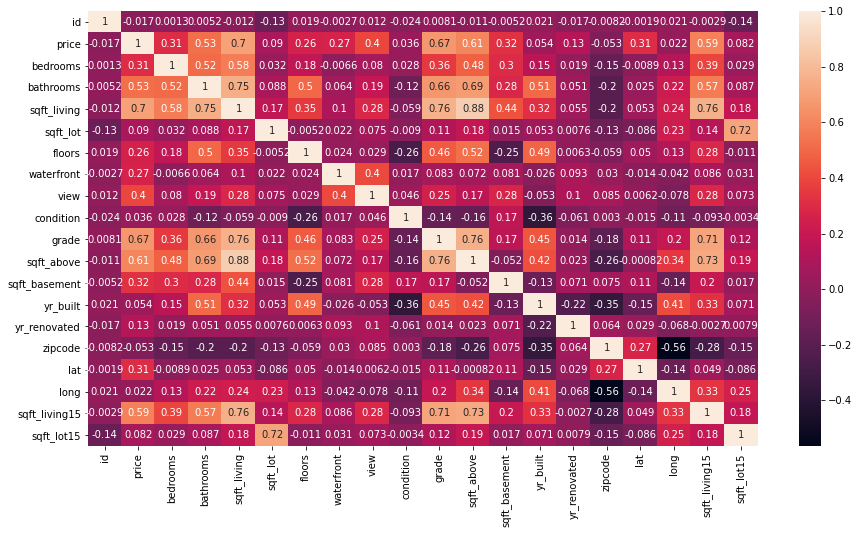

In [4]:
fig = plt.figure(figsize=(15,8))
sns.heatmap(data = df.corr(), annot = True)

### id, zipcode, long, condition, yr_built, sqft_lot, sqft_lot15 and yr_renovated can be dropped as they have very less correlation with price

In [5]:
df.drop(['id', 'zipcode', 'long', 'condition', 'yr_built', 'sqft_lot', 'sqft_lot15', 'yr_renovated'], axis=1, inplace=True)

In [6]:
df.drop('date', axis=1, inplace=True)

### let's see the correlation between sqft_living sqft_living15, sqft_basement and sqft_above

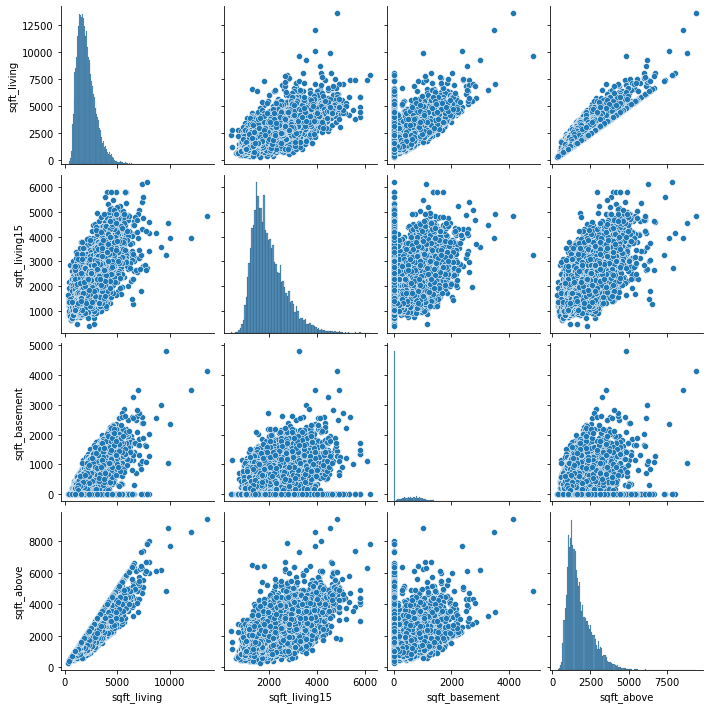

In [7]:
sns.pairplot(data=df[['sqft_living', 'sqft_living15', 'sqft_basement', 'sqft_above']])

* ### sqft_living and sqft_above have very high correlation hence we select only sqft_living as it has higher correlation with price

In [8]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'],
      dtype='object')

In [9]:
df_copy = df.copy(deep=True)

In [10]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [11]:
len(df)

21613

<AxesSubplot:xlabel='bedrooms'>

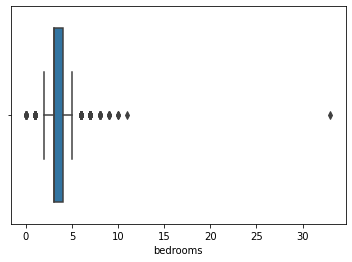

In [12]:
sns.boxplot(x = df['bedrooms'])

In [13]:
df.drop(df.loc[df['bedrooms']>=9].index, inplace=True)

In [14]:
df['floors'].value_counts()

1.0    10678
2.0     8234
1.5     1910
3.0      613
2.5      159
3.5        8
Name: floors, dtype: int64

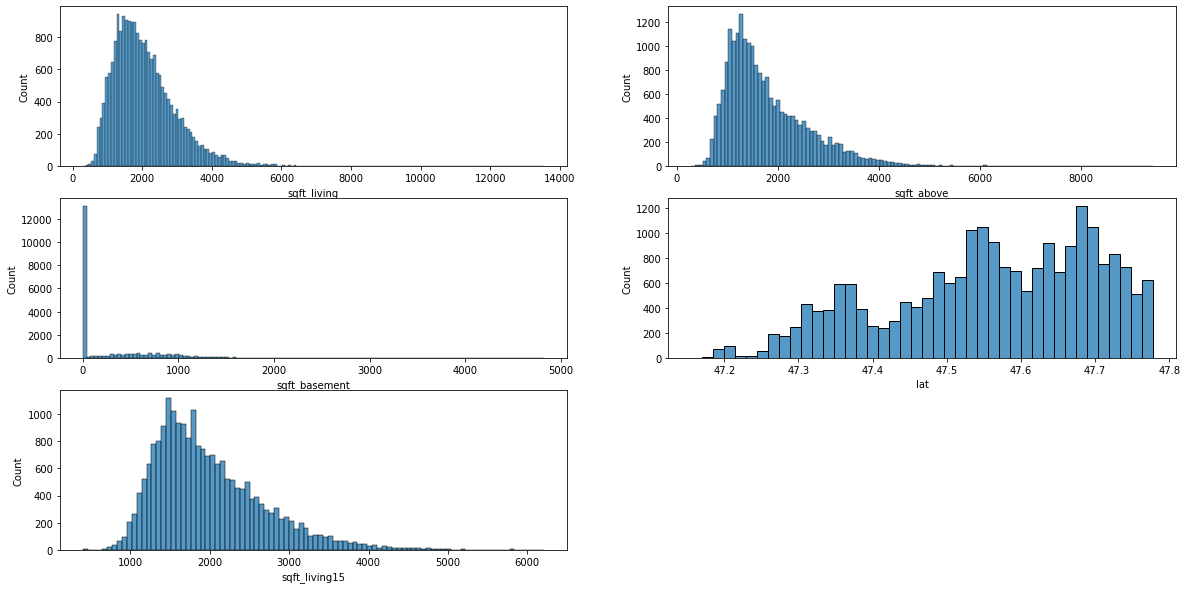

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ls = ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']
j = 1
for i in ls:
    plt.subplot(3, 2, j)
    sns.histplot(x=df[i])
    j += 1

<AxesSubplot:xlabel='sqft_living15', ylabel='Count'>

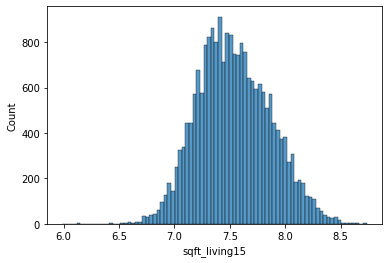

In [16]:
sns.histplot(x = np.log(df['sqft_living15']))

<AxesSubplot:xlabel='sqft_above', ylabel='Count'>

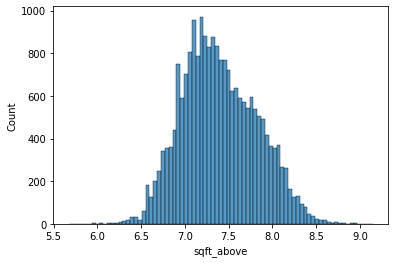

In [17]:
sns.histplot(x = np.log(df['sqft_above']))

In [41]:
class custBedroom(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(X[X['bedrooms']>=9].index, axis = 1)
        return X

retain_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_basement', 'lat']

# sqft_above and sqft_living are included in 2nd transformer

transformer = ColumnTransformer(transformers=[
    ('custBedroom', custBedroom(), retain_columns),
    ('log_transform', FunctionTransformer(np.log), ['sqft_above', 'sqft_living15'])
])

train_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', StandardScaler()),
])

In [44]:
X = df.drop('price', axis=1)
y = df['price']
X = train_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# pd.concat
# .to_csv('kc_processed.csv', index=False)

In [55]:
sgd = SGDRegressor()
rdf = RandomForestRegressor()
lasso = Lasso()
gd = GradientBoostingRegressor()
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')
rg = Ridge()
model_list = [sgd, rdf, lasso, gd, svr_lin, svr_rbf, rg]

In [56]:
for i in model_list:
    i.fit(X_train, y_train)
    y_preds = i.predict(X_test)
    score = r2_score(y_test, y_preds)
    print(i, "\nr2 score : ", score, "\n")

SGDRegressor() 
r2 score :  0.6695191261134306 

RandomForestRegressor() 
r2 score :  0.829576788475997 

Lasso() 
r2 score :  0.6711411760476815 

GradientBoostingRegressor() 
r2 score :  0.8168912238166253 

SVR(kernel='linear') 
r2 score :  0.09538889082872704 

SVR() 
r2 score :  -0.05466540993695257 

Ridge() 
r2 score :  0.6711316289104948 



## here the ensemble models give better results

In [57]:
class LinearRegression() :
      
    def __init__( self, learning_rate, iterations ) :
          
        self.learning_rate = learning_rate
          
        self.iterations = iterations
          
    # Function for model training
              
    def fit( self, X, Y ) :
          
        # no_of_training_examples, no_of_features
          
        self.m, self.n = X.shape
          
        # weight initialization
          
        self.W = np.zeros( self.n )
          
        self.b = 0
          
        self.X = X
          
        self.Y = Y
          
          
        # gradient descent learning
                  
        for i in range( self.iterations ) :
              
            self.update_weights()
              
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights( self ) :
             
        Y_pred = self.predict( self.X )
          
        # calculate gradients  
      
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.m
       
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
          
        # update weights
      
        self.W = self.W - self.learning_rate * dW
      
        self.b = self.b - self.learning_rate * db
          
        return self
      
    # Hypothetical function  h( x ) 
      
    def predict( self, X ) :
      
        return X.dot( self.W ) + self.b

In [58]:
model = LinearRegression( iterations = 1000, learning_rate = 0.01 )
model.fit( X_train, y_train )
y1_pred = model.predict(X_test)
r2_score(y_test, y1_pred)

0.6589522087981192

## the custom model works better than support vector machines but the results are comparable to sgd regressor